In [1]:
import numpy
%matplotlib inline
from matplotlib import pyplot

In [2]:
import sys
sys.path.append('../scripts/')

# Our helper
from plot_helper import *

In the previous notebook, we visually explained what are eigenvectors and eigenvalues, and we can use `numpy.linalg.eig` to solve for the eigenpairs. Take $\,A = \begin{bmatrix} 1 & 0 \\ 1 & 3 \end{bmatrix}$ as an example.

In [3]:
A = numpy.array([[1,0], [1,3]])
D, C = numpy.linalg.eig(A)
print(C)

[[ 0.          0.89442719]
 [ 1.         -0.4472136 ]]


$D$ is an array of eigenvalues and each column of $C$ represents a normalized eigenvector of matrix $A$. Let us draw both eigenvectors along with this linear transformation.

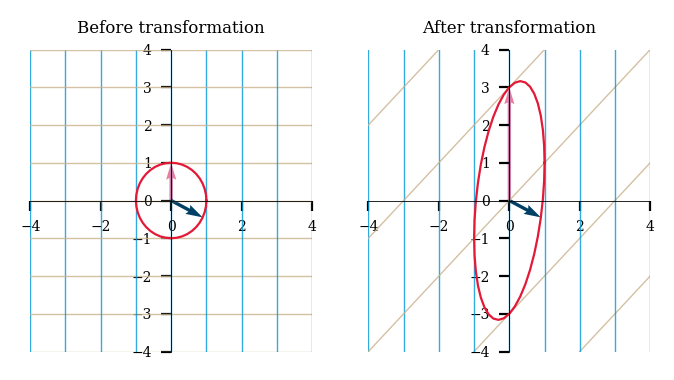

In [4]:
plot_linear_transformation(A, C[:,0], C[:,1], unit_vector=False, unit_circle=True)

We observed that the eigenvectors of a matrix $A$ will not change their directions after the transformation, therefore, they are considered very special to $A$. Besides, since the matrix $A$ transforms a unit circle into an ellipse, there is another interesting pair of vectors -  the vectors on the major and minor axis of this ellipse. They are intriguing because they are most stretched and most shrunk vectors after the transformation. Let us find them first.

In [5]:
alpha = numpy.linspace(0, 2*numpy.pi, 201)
circle = numpy.vstack((numpy.cos(alpha), numpy.sin(alpha)))
ellipse = A @ circle    # 2 by 41 ndarray
distance = numpy.linalg.norm(ellipse, axis=0)
major_id = numpy.argmax(distance)
minor_id = numpy.argmin(distance)
major = ellipse[:, major_id]
minor = ellipse[:, minor_id]
print(major, numpy.linalg.norm(major))
print(minor, numpy.linalg.norm(minor))

[0.33873792 3.16138023] 3.1794761076254896
[-0.94088077  0.07533299] 0.943891774007311


Recall that `major` and `minor` are transformed vectors which had a unit length before the transformation. To use our plotting function `plot_linear_transformation` to visualize them, we need to pass in the corresponding `major` and `minor` vectors before the transformation.

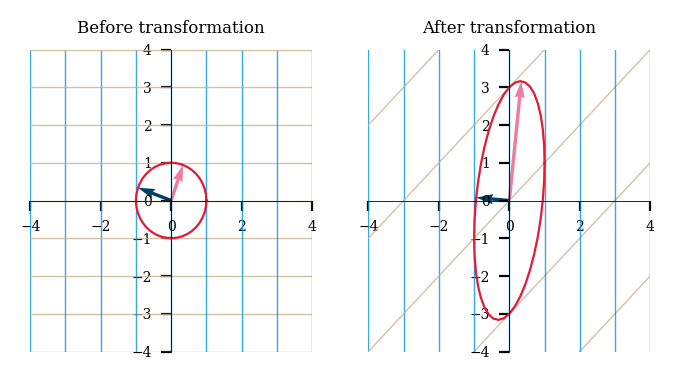

In [6]:
A_inv = numpy.linalg.inv(A)
major_before = A_inv @ major
minor_before = A_inv @ minor
plot_linear_transformation(A, major_before, minor_before, unit_vector=False, unit_circle=True)

We all know that the major and minor axes of an ellipse are orthogonal (perpendicular to each other), however, to our surprise, their corresponding vectors landing on the original unit circle appear to be orthogonal as well. Use inner product to confirm.

In [7]:
print(major.dot(minor))
print(major_before.dot(minor_before))

-0.08055576420695432
1.1102230246251565e-16


If we use $\mathbf{u_1}, \mathbf{u_2}$ to denote the **normalized** `major` and `minor` vectors, use $\mathbf{s_1}, \mathbf{s_2}$ to denote the scaling factor and use $\mathbf{v_1}, \mathbf{v_2}$ to denote `major_before` and `minor_before`, we can express the observation above as:

$$
\begin{align*}
  A \mathbf{v_1} = s_1 \mathbf{u_1} \\
  A \mathbf{v_2} = s_2 \mathbf{u_2}
\end{align*}
$$

Stacking two equations together:

$$
  A \begin{bmatrix}
    \mathbf{v_1} & \mathbf{v_2}
    \end{bmatrix}
    =
    \begin{bmatrix}
    \mathbf{u_1} & \mathbf{u_2}
    \end{bmatrix}
    \begin{bmatrix}
    s_1 & 0 \\
    0 & s_2
    \end{bmatrix}  
$$

Using $V$ to denote $\begin{bmatrix} \mathbf{v_1} & \mathbf{v_2} \end{bmatrix}$, $U$ to denote $\begin{bmatrix} \mathbf{u_1} & \mathbf{u_2} \end{bmatrix}$ and $S$ to denote the diagonal scaling matrix, it becomes:

$$
  A\, V = U\, S
$$

then right-multiply by $V^{-1}$ on both sides:

$$
  A = U\, S\, V^{-1}
$$

Since $\mathbf{v_1}, \mathbf{v_2}$ are orthogonal unit vectors, the matrix $V$ is an orthogonal matrix. (Recall what is an orthogonal matrix from the previous notebook) Thus, $V^T = V^{-1}$, the equation can also be written as:

$$
  A = U\, S\, V^{T}
$$

Starting from discovering the semi-axis of the transformed unit circle, we finally arrive at a neat decomposition of the matrix $A$ - singular value decomposition (SVD). The columns of $U$ are called left singular vectors, the columns of $V$ are called right singular vectors, and the diagonal elements of $S$ are singular values.

Let us build these matrices first.

In [8]:
s1 = numpy.linalg.norm(major)
s2 = numpy.linalg.norm(minor)
S = numpy.diag([s1, s2])
print(S)

[[3.17947611 0.        ]
 [0.         0.94389177]]


In [9]:
u1 = major / s1
u2 = minor / s2
U = numpy.transpose(numpy.vstack((u1,u2)))
print(U)

[[ 0.10653891 -0.99681001]
 [ 0.99430853  0.07981105]]


In [10]:
v1 = major_before
v2 = minor_before
VT = numpy.vstack((v1,v2))
print(VT)

[[ 0.33873792  0.94088077]
 [-0.94088077  0.33873792]]


We can retrieve matrix $A$ by multiplying them together.

In [11]:
U @ S @ VT

array([[1., 0.],
       [1., 3.]])

From the previous notebook, we know that an orthogonal matrix ($U$ and $V$) implies a rotation transformation while a diagonal matrix ($S$) implies a scaling transformation. Let us visualize each component in the SVD. We also draw the unit vectors after each transformation.

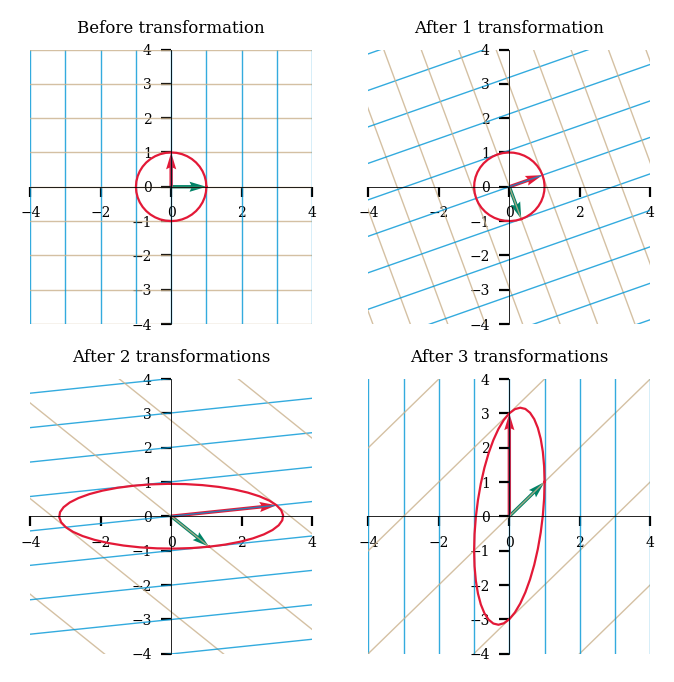

In [12]:
plot_linear_transformations(VT, S, U, unit_circle=True)

The matrix $V^T$ first "rotates" the unit circle, then the diagonal matrix $S$ "stretches" the unit circle in both $x$-axis and $y$-axis directions into an ellipse, finally the matrix $U$ "rotates" this ellipse to a new direction. Therefore, the linear transformation of matrix $A$ can be viewed as a combination of rotation and scaling.

## Compute SVD in Python

You can compute the SVD of a matrix using [`numpy.linalg.svd()`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.svd.html). It returns a tuple: its first element is a 2D array where each column is a left singular vector, its second element is an array with the singular values, and its third element is a 2D array where each row is a right singular vector.

In [13]:
U, S, VT = numpy.linalg.svd(A)

Let us loop over each pair of singular values and vectors, and check if $A v_i$ equals to $s_i u_i$ using [`numpy.allclose()`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.allclose.html).

In [14]:
for u, s, v in zip(U.T, S, VT):
    print(s, u, v)
    print(numpy.allclose(A.dot(v), s*u))

3.1795868015587248 [0.10911677 0.99402894] [0.34694625 0.93788501]
True
0.9435188240589355 [ 0.99402894 -0.10911677] [ 0.93788501 -0.34694625]
True


In [15]:
A_decomp = U @ numpy.diag(S) @ VT
print(A_decomp)

[[ 1.00000000e+00 -3.88578059e-16]
 [ 1.00000000e+00  3.00000000e+00]]


In [16]:
u0, u1 = U[:,0], U[:,1]
v0, v1 = VT[0], VT[1]

In [17]:
S[0]*numpy.outer(u0, v0) + S[1]*numpy.outer(u1, v1)

array([[ 1.00000000e+00, -3.88578059e-16],
       [ 1.00000000e+00,  3.00000000e+00]])

Let us move to a $3 \times 3$ matrix and plot each component in SVD.

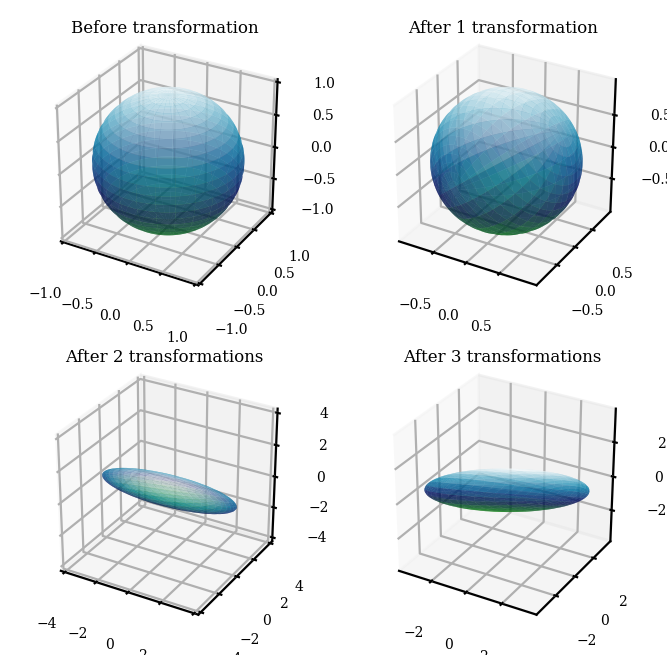

In [18]:
A = numpy.array([[1,2,3], [1,1,1], [-1,1,0]])
U, S, VT = numpy.linalg.svd(A)
plot_3d_linear_transformations(VT, numpy.diag(S), U, unit_sphere=True)

### Rank-deficient matrix

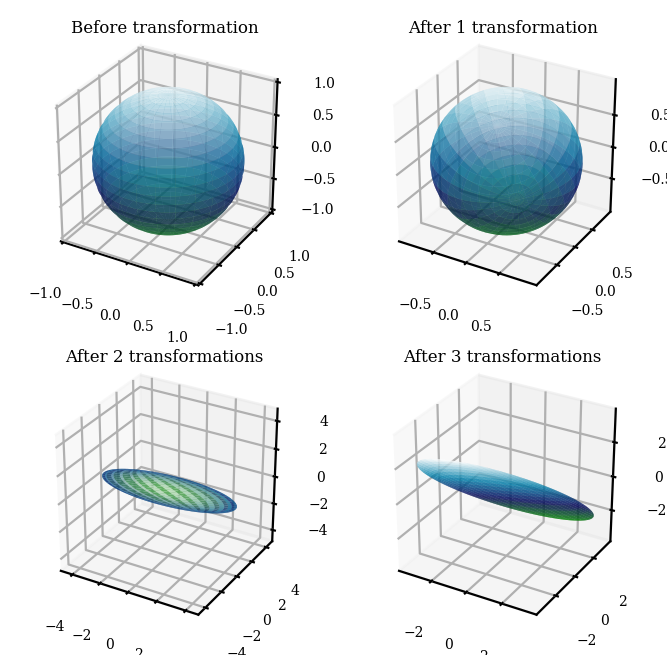

In [19]:
A = numpy.array([[1,2,3], [1,2,1], [-1,-2,0]])
U, S, VT = numpy.linalg.svd(A)
plot_3d_linear_transformations(VT, numpy.diag(S), U, unit_sphere=True)

As what we have discussed in notebook 2, this transformation squishes the unit sphere into a surface, so the matrix $A$ has a rank of $2$. Can we get some insights out of the SVD? Try taking a look at the singular values and vectors.

In [20]:
for u, s, v in zip(U.T, S, VT):
    print(s, u, v)

4.667664063587198 [-0.77013818 -0.51112768  0.38162243] [-0.35625706 -0.71251413 -0.60448699]
1.7924598153087405 [ 0.57918789 -0.30966329  0.75408888] [-0.2703348  -0.5406696   0.79661501]
3.324800927586669e-17 [-0.26726124  0.80178373  0.53452248] [ 8.94427191e-01 -4.47213595e-01 -4.69203869e-17]


There are only two nonzero singular values. The third one is zero, indicating that the scaling transformation represented by $S$ stretches the unit sphere in $x$ and $y$ directions but squashes the sphere onto the $z=0$ plane (in the third plot).

##### Key idea:

> The number of nonzero singular values of square matrix $A$ equals to its rank.


##### Challenge:

> Check the singular values of a rank-1 matrix.

### Nonsquare matrix

So far, we have only talked about square matrices. A $2\times 2$ matrix transforms a 2d vector to another 2d vector, and a $3\times 3$ matrix transforms a 3d vector to another 3d vector. What about a nonsquare matrix, for example, a $3 \times 2$ matrix $M =  \begin{bmatrix} 1 & 0 \\ 1 & 1 \\ 2 & 3\end{bmatrix}$ ?

It transforms a 2d vector to a 3d vector.

If we use $\mathbf{i}$ and $\mathbf{j}$ to denote the standard basis vectors. The first column corresponds to the vector where $\mathbf{i}$ lands after the transformation, and the second column is where $\mathbf{j}$ lands:
$$
\mathbf{i} = \begin{bmatrix} 1 \\ 0 \end{bmatrix}  \Rightarrow  \begin{bmatrix} 1 \\ 1 \\ 2 \end{bmatrix} \\
\mathbf{j} = \begin{bmatrix} 0 \\ 1 \end{bmatrix}  \Rightarrow  \begin{bmatrix} 0 \\ 1 \\ 3 \end{bmatrix}
$$

so a vector $\mathbf{x} = \begin{bmatrix} x \\ y \end{bmatrix}$ will land in $ M\mathbf{x} = x \cdot \begin{bmatrix} 1 \\ 1 \\ 2 \end{bmatrix} + y \cdot \begin{bmatrix} 0 \\ 1 \\ 3 \end{bmatrix}$.

##### Key idea:

> An $m\times n$ nonsquare matrice transforms an $n$-dimensional vector to an $m$-dimensional vector.

You can also multiply a nonsquare matrix with another nonsquare matrix, which represents the composition of two linear transformations between dimensions. However, we need to double check the dimensionality of the two matrices.

### SVD for nonsquare matrices

Back to the mathematical representation:

$$
  A \begin{bmatrix}
    \mathbf{v_1} & \mathbf{v_2} & \mathbf{v_3}
    \end{bmatrix}
    =
    \begin{bmatrix}
    \mathbf{u_1} & \mathbf{u_2} & \mathbf{u_3}
    \end{bmatrix}
    \begin{bmatrix}
    s_1 & 0 & 0\\
    0 & s_2 & 0\\
    0 & 0 & s_3
    \end{bmatrix}  
$$

$$
\begin{align*}
  A &=
    \begin{bmatrix}
    \mathbf{u_1} & \mathbf{u_2} & \mathbf{u_3}
    \end{bmatrix}
    \begin{bmatrix}
    s_1 & 0 & 0\\
    0 & s_2 & 0\\
    0 & 0 & s_3
    \end{bmatrix} 
    \begin{bmatrix}
    \mathbf{v_1}^T \\ \mathbf{v_2}^T \\ \mathbf{v_3}^T
    \end{bmatrix} \\
    &=
    \mathbf{u_1} s_1 \mathbf{v_1}^T + \mathbf{u_2} s_2 \mathbf{v_2}^T + \mathbf{u_3} s_3 \mathbf{v_3}^T \\
\end{align*}
$$

In [21]:
# Execute this cell to load the notebook's style sheet, then ignore it
from IPython.core.display import HTML
css_file = '../style/custom.css'
HTML(open(css_file, "r").read())